In [32]:
import numpy as np
from scipy.signal import butter, lfilter
from scipy.io import loadmat
import pandas as pd
from sklearn.model_selection  import train_test_split
from mne.decoding import CSP
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pylab as plt
import spkit as sp

# View Data

In [15]:
mat  = loadmat("BCI/A03T.mat")

In [16]:
mat['data'][0][3][0][0][0][0].shape

(25,)

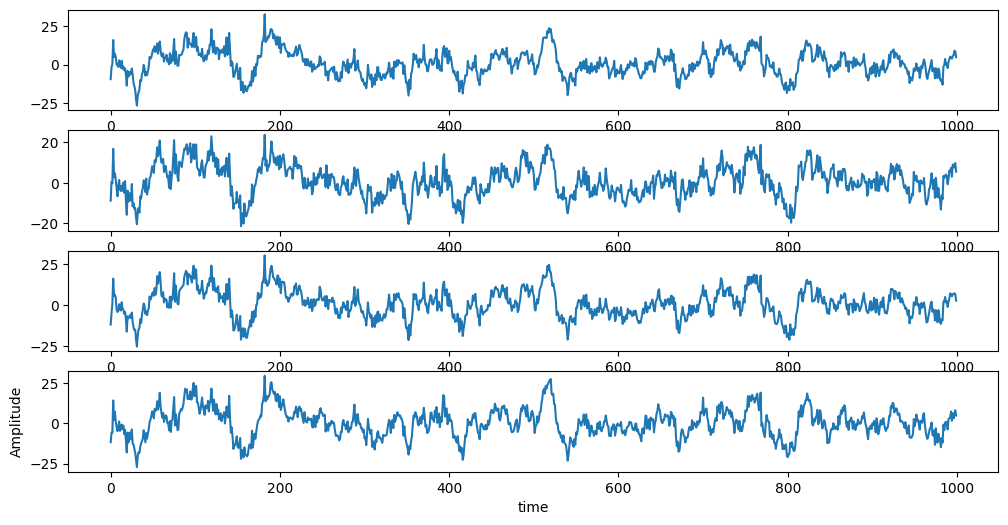

In [22]:
dataset = mat['data']
finalResult_x = np.empty([1, 22, 1500-500]) # signals
finalResult_y = np.empty([1])              # labels
N  = data.shape[1]              # number of samples


# iteration on motor imagery task sessions (left hand, right hand, feet, tongue)
# iterative from 3 to 8 => 6 runs 
# each run callect 48 trials
# then 6*48 = 288 trials

# The signals were obtained using 22 electrodes for EEG and 3 electrodes for EOG => 22+3 = 25 channel
# each signal have 25 channel and number of signals is ~ 10000

samples = dataset[0][3][0][0][0] # whole signal of the session
trials  = dataset[0][3][0][0][1] # indices of successive trials


x = samples[trials[0,0]:trials[1,0]]
x = x[500: 1500, 0: -3].T
plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(x[0])
plt.subplot(412)
plt.plot(x[1])
plt.subplot(413)
plt.plot(x[2])
plt.subplot(414)
plt.plot(x[3])
plt.xlabel("time")
plt.ylabel("Amplitude")
plt.show()

        

In [3]:
pd.DataFrame(mat['data'][0][3][0][0][4]) # signals

,0,1,2,3
0,[left hand],[right hand],[feet],[tongue]


In [28]:
pd.DataFrame(mat['data'][0][3][0][0][5]) # trials

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [245]:
pd.DataFrame(mat['data'][0][3][0][0][2]) # labels

,0
0,4
1,3
2,2
3,1
4,1
5,2
6,3
7,4
8,2
9,3


# Preprocessing

In [23]:
# Band Pass Filter with low cut of 4 hz and high cut of 38 hz
# This choice is because of the fact that motor imagery features generally happen in alpha and beta band of EEG.
def butter_bandpass (lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter (signal, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, signal)
    return y


def Preprocessing(path):
    # load data
    mat  = loadmat(path)
    data = mat['data']
    
    finalResult_x = np.empty([1, 22, 1500-500]) # signals
    finalResult_y = np.empty([1])              # labels
    N  = data.shape[1]              # number of samples


    # iteration on motor imagery task sessions (left hand, right hand, feet, tongue)
    # iterative from 3 to 8 => 6 runs 
    # each run callect 48 trials
    # then 6*48 = 288 trials
    
    # The signals were obtained using 22 electrodes for EEG and 3 electrodes for EOG => 22+3 = 25 channel
    # each signal have 25 channel and number of signals is ~ 10000
    
    for j in range(3,N):
        samples = data[0][j][0][0][0] # whole signal of the session
        trials  = data[0][j][0][0][1] # indices of successive trials
        labels  = data[0][j][0][0][2] # labels of corresponding task

        # iteration on tasks in each session
        for i in range(48):
            
            # we interested on signals between trials so we store it in x variable 
            if i < 47:
                x = samples[trials[i,0]:trials[i+1,0]]
            else:
                x = samples[trials[i,0]:]
            
            # remove the last 3 channels (EOG) and transpose the matrix
            x = x[500: 1500, 0: -3].T

            # apply band pass filter
            x = butter_bandpass_filter(
                signal  = x,
                lowcut  = 4,
                highcut = 38,
                fs      = 250,
                order   = 6
            )
            x=x.T
            x = sp.eeg.ICA_filtering(x.copy(),verbose=1,winsize=250)
            
            x=x.T
            
            # normalize
            x = (x - np.mean(x))/np.std(x)

            x = np.expand_dims(x, axis=0)
            y = np.array([labels[i,0]])

            finalResult_x = np.concatenate((finalResult_x, x),axis=0)
            finalResult_y = np.concatenate((finalResult_y, y),axis=0)

    return finalResult_x[1:], finalResult_y[1:] # first sample is empty
    
    

In [19]:
np.arange(-11,10).shape

(21,)

In [11]:
data, labels = Preprocessing('BCI/A03T.mat')
data_test, labels_test = Preprocessing('BCI/A03E.mat')

(1000, 22)
ICA Artifact Removal : extended-infomax
100.09%|##################################################|1125\1126|
Done..
(1000, 22)
(22, 1000)
ICA Artifact Removal : extended-infomax
100.09%|##################################################|1125\1126|
Done..
ICA Artifact Removal : extended-infomax
100.09%|##################################################|1125\1126|
Done..
ICA Artifact Removal : extended-infomax
100.09%|##################################################|1125\1126|
Done..
ICA Artifact Removal : extended-infomax
100.09%|##################################################|1125\1126|
Done..
ICA Artifact Removal : extended-infomax
100.09%|##################################################|1125\1126|
Done..
ICA Artifact Removal : extended-infomax
100.09%|##################################################|1125\1126|
Done..
ICA Artifact Removal : extended-infomax
100.09%|##################################################|1125\1126|
Done..
ICA Artifact Removal : extended

KeyboardInterrupt: 

In [4]:
np.array(labels).shape

(288,)

In [22]:
# convert labels from list of float to list of int 
labels=[int(x) for x in labels]
labels_test=[int(x) for x in labels_test]
labels=np.array(labels)
labels_test=np.array(labels_test)

In [28]:
data = np.load('Preprocessed_data/train_x_with_ICA.npy')
labels = np.load('Preprocessed_data/train_y_with_ICA.npy')
data_test = np.load('Preprocessed_data/test_x_with_ICA.npy')
labels_test = np.load('Preprocessed_data/test_y_with_ICA.npy')

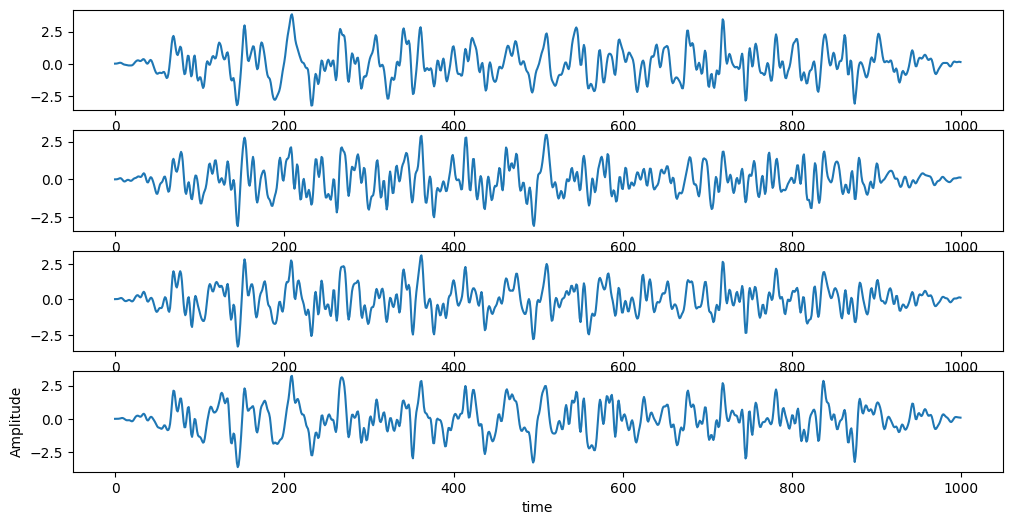

In [29]:
x=data[0]
plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(x[0])
plt.subplot(412)
plt.plot(x[1])
plt.subplot(413)
plt.plot(x[2])
plt.subplot(414)
plt.plot(x[3])
plt.xlabel("time")
plt.ylabel("Amplitude")
plt.show()

# Feature Extraction

In [30]:
data.shape

(288, 22, 1000)

In [31]:
data.shape,data_test.shape,labels.shape,labels_test.shape

((288, 22, 1000), (288, 22, 1000), (288,), (288,))

In [11]:
data=np.concatenate((data,data_test))
labels=np.concatenate((labels,labels_test))

In [12]:
data.shape,labels.shape

((576, 22, 1000), (576,))

In [13]:
csp = CSP(n_components=4)
csp.fit(data,labels)
data_csp= csp.transform(data)
# data_test_csp  = csp.transform(data_test)

Computing rank from data with rank=None
    Using tolerance 5.2 (2.2e-16 eps * 22 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.3 (2.2e-16 eps * 22 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5 (2.2e-16 eps * 22 dim * 1e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.2 (2.2e-16 eps * 22 dim * 1.1e+15  max singular value)
    Estimated rank (

In [65]:
pd.DataFrame(data_csp)


,0,1,2,3
0,-0.958092,-0.296318,0.336732,-0.386217
1,-0.699945,0.307065,0.604179,-0.067429
2,-1.045077,0.106419,0.345492,-0.134801
3,0.910082,-0.641971,-0.070261,-0.166931
4,-1.100223,0.039846,0.379715,-0.001982
...,...,...,...,...
571,-0.136615,0.349800,-0.119729,0.140445
572,-0.092930,-0.077395,-0.162639,0.300888
573,0.361273,0.324515,-0.202514,-1.021773
574,-0.204123,-0.485426,0.331235,0.103777


# Split data

In [15]:
x_train,x_test ,y_train,y_test = train_test_split(data_csp,labels,test_size = 0.25 , random_state =42 , shuffle = True,stratify = labels )
x_train.shape,x_test.shape ,y_train.shape,y_test.shape

((432, 4), (144, 4), (432,), (144,))

# Classifiers

In [29]:
randomforest =RandomForestClassifier().fit(x_train,y_train)
y_te_random = randomforest.predict(x_test)

clf = svm.SVC().fit(x_train, y_train)
y_svm = clf.predict(x_test)

knn = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)
knn_pred = knn.predict(x_test)

lm = LogisticRegression(multi_class='ovr', solver='liblinear').fit(x_train, y_train)
lm_pred = lm.predict(x_test)

print("Random Forst =",accuracy_score(y_te_random,y_test)*100)
print("SVM =",accuracy_score(y_svm,y_test)*100)
print("KNN =",accuracy_score(knn_pred,y_test)*100)
print("Logistic Regression =",accuracy_score(lm_pred,y_test)*100)

Random Forst = 83.33333333333334
SVM = 86.80555555555556
KNN = 83.33333333333334
Logistic Regression = 85.41666666666666


In [31]:
clf_rbf = svm.SVC(kernel='rbf',gamma=0.5,C=0.1).fit(x_train, y_train)
svm_rbf = clf_rbf.predict(x_test)
print("SVM_rbf =",accuracy_score(svm_rbf,y_test)*100)
clf_poly = svm.SVC(kernel='poly',degree=3,C=1).fit(x_train, y_train)
svm_poly = clf_poly.predict(x_test)
print("SVM_poly =",accuracy_score(svm_poly,y_test)*100)

SVM_rbf = 84.02777777777779
SVM_poly = 76.38888888888889


In [25]:
print(classification_report(y_test,y_svm))
print(classification_report(y_test,lm_pred))


              precision    recall  f1-score   support

           1       0.92      0.94      0.93        36
           2       0.94      0.92      0.93        36
           3       0.79      0.86      0.83        36
           4       0.82      0.75      0.78        36

    accuracy                           0.87       144
   macro avg       0.87      0.87      0.87       144
weighted avg       0.87      0.87      0.87       144

              precision    recall  f1-score   support

           1       0.90      1.00      0.95        36
           2       0.97      0.92      0.94        36
           3       0.73      0.89      0.80        36
           4       0.85      0.61      0.71        36

    accuracy                           0.85       144
   macro avg       0.86      0.85      0.85       144
weighted avg       0.86      0.85      0.85       144



# Save model & data

In [3]:
import joblib

# save model
#joblib.dump(clf, "models/my_svm.joblib")

In [30]:

# load model
loaded_rf = joblib.load("models/my_svm.joblib")

y_val_random = loaded_rf.predict(x_test)
print("SVM =",accuracy_score(y_val_random,y_test)*100)


SVM = 86.80555555555556


In [43]:
guiData=x_test[-10:]
#np.save("gui_data/guiData",guiData)

# GUI

In [8]:
import tkinter as tk

In [43]:
# load model & data (contain 10 signals)
arrows = {3:"foot", 4:"tongue", 1:"left hand", 2:"right hand"}
loaded_rf = joblib.load("models/my_svm.joblib")
guiData=np.load("gui_data/guiData.npy")


In [53]:

my_window=tk.Tk()
count=0

# make prediction and draw arrow based on predicion
def make_prediction(event):
    global count
    y_val_random = np.array(loaded_rf.predict(guiData)).tolist()
    draw_arrow(arrows[y_val_random[count]])
    count+=1
    print(count)
    
# drow arrows (up, down, left, right)
def draw_arrow(prediction):
    if prediction == "foot":
        my_canvas.create_line(250,100,250,200,fill='black',width=5,arrow='first')
    elif prediction == "tongue":
        my_canvas.create_line(250,300,250,400,fill='black',width=5,arrow='last')
    elif prediction == "left hand":
        my_canvas.create_line(100,250,200,250,fill='black',width=5,arrow='first')
    elif prediction == "right hand":
        my_canvas.create_line(300,250,400,250,fill='black',width=5,arrow='last')

# delete arrow from screen window
def delete_arrow(event):
    my_canvas.delete('all')
    
# set the size of screen window
my_canvas=tk.Canvas(my_window,width=500,height=500,background='white')

# call make_prediction function when clicking the left button on mouse
my_canvas.bind('<Button-1>',make_prediction)

# call delete_arrow function when clicking the right button on mouse
my_canvas.bind('<Button-3>',delete_arrow)
my_canvas.grid(row=0,column=0)
my_window.mainloop()

1
2
3
4
5
6
7
8
9
10
